In [ ]:
# Vamshi Vallala
# Deep Learning Project Stage 5

In [ ]:
!pip show requests


Name: requests
Version: 2.27.1
Summary: Python HTTP for Humans.
Home-page: https://requests.readthedocs.io
Author: Kenneth Reitz
Author-email: me@kennethreitz.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: certifi, charset-normalizer, idna, urllib3
Required-by: CacheControl, community, earthengine-api, fastai, folium, gcsfs, gdown, google-api-core, google-cloud-bigquery, google-cloud-storage, google-colab, gspread, kaggle, moviepy, music21, pandas-datareader, panel, pooch, pymystem3, requests-oauthlib, spacy, Sphinx, tensorboard, tensorflow-datasets, torchdata, torchtext, torchvision, tweepy, yfinance


# Imports

In [ ]:
# base imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from collections import defaultdict

from glob import glob
import random
import math

In [ ]:
# more imports
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder

import tarfile
from scipy import stats
from sklearn.metrics import mean_squared_error
from functools import partial
from tensorflow.math import confusion_matrix
import seaborn as sns
from sklearn.metrics import f1_score

# tf imports
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout, AlphaDropout, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.initializers import he_normal, lecun_normal
from tensorflow.keras.optimizers import SGD, Adam, Adamax, Nadam, RMSprop
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

# Access Data from Google Drive

In [ ]:
# @title Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Define paths and get data in runtime storage

In [ ]:
# @title Set paths to TFrecord data
drive_path_sharded = "/content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/tfr_data/stage345_sharded/"
drive_path_5_sharded = "/content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/tfr_data/stage5all_sharded/"
drive_path_imagenette = "/content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/tfr_data/imagenette/"

colab_path_sharded = "/content/stage345_sharded/"
colab_path_5_sharded = "/content/stage5all_sharded/"
colab_path_imagenette = "/content/imagenette/"

In [ ]:
%%time
# @title Get TFrecord data in Colab (class data, sharded files)
!cp -r "{drive_path_sharded}" "/content"

CPU times: user 533 ms, sys: 107 ms, total: 639 ms
Wall time: 1min 43s


In [ ]:
%%time
# @title Get TFrecord data in Colab (class data (train+val), sharded files)
!cp -r "{drive_path_5_sharded}" "/content"

CPU times: user 535 ms, sys: 94.9 ms, total: 630 ms
Wall time: 1min 41s


In [ ]:
%%time
# @title Get TFrecord data in Colab (imagenette data, sharded files)
!cp -r "{drive_path_imagenette}" "/content"

CPU times: user 442 ms, sys: 80.4 ms, total: 523 ms
Wall time: 1min 36s


# Hardware setup

In [ ]:
# TPU or GPU detection
# Detect hardware, return appropriate distribution strategy
tpu = tf.distribute.cluster_resolver.TPUClusterResolver() if 'COLAB_TPU_ADDR' in os.environ else None
if tpu:
  print("TPU")
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
  REPLICAS = strategy.num_replicas_in_sync
  BATCH_SIZE = 32
  # BATCH_SIZE = 32 * REPLICAS # keeps breaking (eager execution limits?)
else:
  print("GPU")
  strategy = tf.distribute.get_strategy()
  REPLICAS = strategy.num_replicas_in_sync
  BATCH_SIZE = 32 # Works on Colab Pro GPU, with ~8 million params. Could do w/ boosted RAM....
  # BATCH_SIZE = 128 # For when I ball out

  # Enable mixed precision - ONLY for GPU use
  tf.keras.mixed_precision.set_global_policy('mixed_float16')


AUTO = tf.data.AUTOTUNE
NUM_PARALLEL_CALLS = 16 * REPLICAS if tpu else AUTO

print(f'AUTO: {AUTO}')
print(f'REPLICAS: {REPLICAS}')
print(f'BATCH_SIZE: {BATCH_SIZE}')
print(f'NUM_PARALLEL_CALLS: {NUM_PARALLEL_CALLS}')

GPU
AUTO: -1
REPLICAS: 1
BATCH_SIZE: 32
NUM_PARALLEL_CALLS: -1


# Read images from TFRecords files into datasets

In [ ]:
# @title Functions to parse instances and read tfrecords (class data)
label_map = {
    "bell": 0,
    "dog": 1,
    "horse": 2,
    "house": 3,
    "tiger": 4
}

def _parse_image_function(example):
    image_feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }

    features = tf.io.parse_single_example(example, image_feature_description)
    image = tf.image.decode_png(features['image'], channels=3)
    image = tf.image.resize(image, [512, 512], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = tf.cast(image, tf.float32) / 255.0

    label = tf.cast(features['label'], tf.int32)

    # One-hot, in alphabetical order to match ImageGenerator
    label = features['label']
    label = tf.one_hot(label, depth=len(label_map))

    return image, label

def read_dataset_sharded(filename, batch_size, augment=True, batch_augment=True, cache=False):
  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  filenames = tf.io.gfile.glob(filename + "*.tfrecord")
  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.AUTOTUNE)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(_parse_image_function, num_parallel_calls=NUM_PARALLEL_CALLS)
  dataset = dataset.shuffle(3 * BATCH_SIZE)

  if cache:
      dataset = dataset.cache()

  if augment:
      dataset = dataset.map(data_augment, num_parallel_calls=NUM_PARALLEL_CALLS)

  dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

  if batch_augment:
      dataset = dataset.map(batch_data_augment, num_parallel_calls=NUM_PARALLEL_CALLS)

  # if augment:
  #     dataset = dataset.map(data_augment_post, num_parallel_calls=NUM_PARALLEL_CALLS)

  dataset = dataset.prefetch(tf.data.AUTOTUNE)

  return dataset

def read_dataset(filename, batch_size, augment=True, batch_augment=True, cache=False):
  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filename, num_parallel_reads=tf.data.AUTOTUNE)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(_parse_image_function, num_parallel_calls=NUM_PARALLEL_CALLS)
  dataset = dataset.shuffle(3 * BATCH_SIZE)

  if cache:
      dataset = dataset.cache()

  dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

  if batch_augment:
      dataset = dataset.map(batch_data_augment, num_parallel_calls=NUM_PARALLEL_CALLS)

  if augment:
      dataset = dataset.map(data_augment_post, num_parallel_calls=NUM_PARALLEL_CALLS)

  dataset = dataset.prefetch(tf.data.AUTOTUNE)

  return dataset

In [ ]:
# @title Functions to parse instances and read tfrecords (Imagenette)
label_map_imagenette = {
    "golf_ball": 0,
    "dump_truck": 1,
    "parachute": 2,
    "castle": 3,
    "chainsaw": 4,
    "gas_pump": 5,
    "trombone": 6,
    "dog": 7,
    "speaker": 8,
    "fish": 9
}

def _parse_image_function_imagenette(example):
    image_feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }

    features = tf.io.parse_single_example(example, image_feature_description)
    image = tf.image.decode_png(features['image'], channels=3)
    image = tf.image.resize(image, [512, 512], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = tf.cast(image, tf.float32) / 255.0

    label = tf.cast(features['label'], tf.int32)

    # One-hot, in alphabetical order to match ImageGenerator
    label = features['label']
    label = tf.one_hot(label, depth=len(label_map_imagenette))

    return image, label

def read_dataset_imagenette(filename, batch_size, augment=True, batch_augment=True, cache=False):
  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  filenames = tf.io.gfile.glob(filename + "*.tfrecord")
  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.AUTOTUNE)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(_parse_image_function_imagenette, num_parallel_calls=NUM_PARALLEL_CALLS)
  dataset = dataset.shuffle(3 * BATCH_SIZE)

  if cache:
      dataset = dataset.cache()

  if augment:
      dataset = dataset.map(data_augment, num_parallel_calls=NUM_PARALLEL_CALLS)

  dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

  if batch_augment:
      dataset = dataset.map(batch_data_augment, num_parallel_calls=NUM_PARALLEL_CALLS)

  # if augment:
  #     dataset = dataset.map(data_augment_post, num_parallel_calls=NUM_PARALLEL_CALLS)

  dataset = dataset.prefetch(tf.data.AUTOTUNE)

  return dataset

# Data Augmentation

## Helper functions

In [ ]:
'''
Randomly rotates an image by a given number of degrees, and returns the rotated image.
Does this by generating a rotation matrix, applying it to a list of destination pixel coordinates,
and then finding the origin pixel values at the resulting rotated pixel coordinates.
'''
def transform_rotation(image, height, rotation):
    # For parity purposes, to ensure transformation is valid
    x_dimension = height % 2

    # Randomly rotate image by rotation degrees
    rotation = rotation * tf.random.uniform([1], dtype='float32')

    # Convert degrees to radians
    rotation = math.pi * rotation / 180.

    # Calculate rotation matrix
    cos_theta = tf.math.cos(rotation)
    sin_theta = tf.math.sin(rotation)
    one = tf.constant([1], dtype='float32')
    zero = tf.constant([0], dtype='float32')
    rotation_matrix = tf.reshape(tf.concat([cos_theta, sin_theta, zero, -sin_theta, cos_theta, zero, zero, zero, one], axis=0), [3,3])

    # Generate list of destination pixel coordinates
    x_coords = tf.repeat(tf.range(height // 2, -height // 2, -1), height)
    y_coords = tf.tile(tf.range(-height // 2, height // 2), [height])
    z_coords = tf.ones([height * height], dtype='int32')
    dest_pixel_coords = tf.stack([x_coords, y_coords, z_coords])

    # Rotate destination pixels onto origin pixels
    rotated_pixel_coords = tf.matmul(rotation_matrix, tf.cast(dest_pixel_coords, dtype='float32'))
    rotated_pixel_coords = tf.cast(rotated_pixel_coords, dtype='int32')
    rotated_pixel_coords = tf.clip_by_value(rotated_pixel_coords, -height // 2 + x_dimension + 1, height // 2)

    # Find origin pixel values
    origin_pixel_coords = tf.stack([height // 2 - rotated_pixel_coords[0, :], height // 2 - 1 + rotated_pixel_coords[1, :]])
    pixel_values = tf.gather_nd(image, tf.transpose(origin_pixel_coords))

    return tf.reshape(pixel_values, [height, height, 3])



'''
Randomly applies a shear transformation to an image, and returns the transformed image.
Does this by generating a shear matrix, applying it to a list of destination pixel coordinates,
and then finding the origin pixel values at the resulting transformed pixel coordinates.
'''
def transform_shear(image, height, shear):
    # For parity purposes, to ensure transformation is valid
    x_dimension = height % 2

    # Convert shear from degrees to radians
    shear = shear * tf.random.uniform([1], dtype='float32')
    shear = math.pi * shear / 180.

    # Compute shear matrix
    one = tf.constant([1], dtype='float32')
    zero = tf.constant([0], dtype='float32')
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape(tf.concat([one, s2, zero, zero, c2, zero, zero, zero, one], axis=0), [3, 3])

    # List destination pixel indices
    x = tf.repeat(tf.range(height // 2, -height // 2, -1), height)
    y = tf.tile(tf.range(-height // 2, height // 2), [height])
    z = tf.ones([height * height], dtype='int32')
    destination_indices = tf.stack([x, y, z])

    # Rotate destination pixels onto origin pixels
    transformed_indices = tf.cast(K.dot(shear_matrix, tf.cast(destination_indices, dtype='float32')), dtype='int32')
    transformed_indices = K.clip(transformed_indices, -height // 2 + x_dimension + 1, height // 2)

    # Find origin pixel values
    origin_indices = tf.stack([height // 2 - transformed_indices[0, :], height // 2 - 1 + transformed_indices[1, :]])
    transformed_image = tf.gather_nd(image, tf.transpose(origin_indices))

    return tf.reshape(transformed_image, [height, height, 3])



'''
Shifts an image horizontally and vertically by a given number of pixels, and returns the shifted image.
Does this by generating a shift matrix, applying it to a list of destination pixel coordinates,
and then finding the origin pixel values at the resulting shifted pixel coordinates.
'''
def transform_shift(image, height, h_shift, w_shift):
    # For parity purposes, to ensure transformation is valid
    x_dimension = height % 2

    # Compute random shift amounts
    height_shift = h_shift * tf.random.uniform([1], dtype='float32')
    width_shift = w_shift * tf.random.uniform([1], dtype='float32')

    # Define identity and zero matrices
    identity_matrix = tf.constant([1], dtype='float32')
    zero_matrix = tf.constant([0], dtype='float32')

    # Define shift matrix
    shift_matrix = tf.reshape(tf.concat([identity_matrix, zero_matrix, height_shift,
                                          zero_matrix, identity_matrix, width_shift,
                                          zero_matrix, zero_matrix, identity_matrix], axis=0), [3, 3])

    # List destination pixel indices
    x_indices = tf.repeat(tf.range(height // 2, -height // 2, -1), height)
    y_indices = tf.tile(tf.range(-height // 2, height // 2), [height])
    ones = tf.ones([height * height], dtype='int32')
    pixel_indices = tf.stack([x_indices, y_indices, ones])

    # Rotate destination pixels onto origin pixels
    rotated_indices = K.dot(shift_matrix, tf.cast(pixel_indices, dtype='float32'))
    rotated_indices = K.cast(rotated_indices, dtype='int32')
    rotated_indices = K.clip(rotated_indices, -height // 2 + x_dimension + 1, height // 2)

    # Find origin pixel values
    origin_indices = tf.stack([height // 2 - rotated_indices[0, ], height // 2 - 1 + rotated_indices[1, ]])
    pixel_values = tf.gather_nd(image, tf.transpose(origin_indices))

    return tf.reshape(pixel_values, [height, height, 3])


'''
Randomly applies cutout to an image by masking out a rectangular area.
Does this by generating a binary mask tensor of zeros with the same shape as the image,
randomly determines the size and position of the rectangular area to mask out,
and then applies the mask to the image by element-wise multiplication.
'''
def random_cutout(image, height, width, min_mask_size, max_mask_size, num_masks):
  for i in range(num_masks):
      # Randomly generate the height and width of the mask.
      # mask_height = tf.random.uniform([], minval=min_mask_size[0], maxval=max_mask_size[0], dtype=tf.int32)
      # mask_width = tf.random.uniform([], minval=min_mask_size[1], maxval=max_mask_size[1], dtype=tf.int32)

      mask_height = 56
      mask_width = 56

      # Compute the amount of padding needed to fit the mask in the image.
      pad_h = tf.maximum(height - mask_height, 0)
      pad_w = tf.maximum(width - mask_width, 0)

      # Randomly determine the offset of the mask within the padded area.
      offset_h = tf.random.uniform([], maxval=pad_h, dtype=tf.int32)
      offset_w = tf.random.uniform([], maxval=pad_w, dtype=tf.int32)

      # Create a binary mask tensor of zeros with the shape of the image, and set the
      # appropriate region to ones to mask out that region.
      mask = tf.pad(tf.zeros([mask_height, mask_width, 3], dtype=tf.float32),
                    [[offset_h, pad_h - offset_h], [offset_w, pad_w - offset_w], [0, 0]],
                    constant_values=1)


      # Apply the mask to the image.
      image = image * mask


  image = tf.image.pad_to_bounding_box(
        image,
        offset_height=0,
        offset_width=0,
        target_height=512,
        target_width=512
        )

  return image


## Driver functions

In [ ]:
config = {
  "HEIGHT": 512,
  "WIDTH": 512,
  "CHANNELS": 3
}

def batch_data_augment(images, labels, low=0.4, high=1.0):
    # MixUp
    batch_size = tf.shape(images)[0]
    indices = tf.random.shuffle(tf.range(batch_size))

    shuffled_images = tf.gather(images, indices)
    shuffled_labels = tf.gather(labels, indices)

    # Generate a mixing coefficient for each image in the batch
    lam = tf.random.uniform(shape=(batch_size,), minval=low, maxval=high)

    # Reshape the mixing coefficients to allow broadcasting
    lam_images = tf.reshape(lam, (batch_size, 1, 1, 1))
    lam_labels = tf.reshape(lam, (batch_size, 1))

    mixed_images = lam_images * images + (1 - lam_images) * shuffled_images
    mixed_labels = lam_labels * labels + (1 - lam_labels) * shuffled_labels

    return mixed_images, mixed_labels

def data_augment_post(images, labels):
    augmented_images, augmented_labels = tf.vectorized_map(data_augment_post_main, (images, labels))
    return augmented_images, augmented_labels

def data_augment_post_main(image_label):
    image, label = image_label
    # Randomly apply shear transformation
    p_shear = np.random.uniform()
    if p_shear > .2:
        if p_shear > .6:
            image = transform_shear(image, config['HEIGHT'], shear=20.)
        else:
            image = transform_shear(image, config['HEIGHT'], shear=-20.)

    # Randomly apply rotation transformation
    p_rotation = np.random.uniform()
    if p_rotation > .2:
        if p_rotation > .6:
            image = transform_rotation(image, config['HEIGHT'], rotation=45.)
        else:
            image = transform_rotation(image, config['HEIGHT'], rotation=-45.)

    # Randomly apply rotation transformation
    p_crop = np.random.uniform()
    if p_crop > .2:
        image = data_augment_crop(image)

    # Randomly apply 90deg rotation transformation
    p_rotate = np.random.uniform()
    if p_rotate > .2:
        image = data_augment_rotate(image)


    image = data_augment_flip_transpose(image) # Flip, then randomly transpose
    image = tf.image.random_saturation(image, 0.7, 1.3)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.1)

    # Randomly apply cutout transformation
    p_cutout = np.random.uniform()
    if p_cutout > .5:
        image = data_augment_cutout(image)

    image = tf.image.resize(image, [config["HEIGHT"], config["WIDTH"]])
    return image, label

def data_augment(image, label):
    # Randomly apply shear transformation
    p_shear = np.random.uniform()
    if p_shear > .2:
        if p_shear > .6:
            image = transform_shear(image, config['HEIGHT'], shear=20.)
        else:
            image = transform_shear(image, config['HEIGHT'], shear=-20.)

    # Randomly apply rotation transformation
    p_rotation = np.random.uniform()
    if p_rotation > .2:
        if p_rotation > .6:
            image = transform_rotation(image, config['HEIGHT'], rotation=45.)
        else:
            image = transform_rotation(image, config['HEIGHT'], rotation=-45.)

    # Randomly apply rotation transformation
    p_crop = np.random.uniform()
    if p_crop > .2:
        image = data_augment_crop(image)

    # Randomly apply 90deg rotation transformation
    p_rotate = np.random.uniform()
    if p_rotate > .2:
        image = data_augment_rotate(image)


    image = data_augment_flip_transpose(image) # Flip, then randomly transpose
    image = tf.image.random_saturation(image, 0.7, 1.3)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.1)

    # Randomly apply cutout transformation
    p_cutout = np.random.uniform()
    if p_cutout > .5:
        image = data_augment_cutout(image)

    image = tf.image.resize(image, [config["HEIGHT"], config["WIDTH"]])
    return image, label

def data_augment_crop(image):
    p_crop = np.random.uniform()
    crop_size = np.random.randint(low=int(config['HEIGHT']*.7), high=config['HEIGHT'], dtype=np.int32)

    '''
    Randomly crops or central crops the image based on p_crop value.
    If p_crop > 0.5, a random crop of size [crop_size, crop_size, config['CHANNELS']] is taken.
    If p_crop is between 0.4 and 0.5, a central crop of 70% of the image size is taken.
    If p_crop is between 0.2 and 0.4, a central crop of 80% of the image size is taken.
    If p_crop is less than 0.2, a central crop of 90% of the image size is taken.
    '''
    if p_crop > 0.5:
      image = tf.image.random_crop(image, size=[crop_size, crop_size, config['CHANNELS']])
    elif p_crop > 0.2:
      image = tf.image.central_crop(image, central_fraction=1 - 0.1 * (p_crop // 0.1))

    image = tf.image.resize(image, size=[config['HEIGHT'], config['WIDTH']])

    return image

def data_augment_rotate(image):
    p_rotate = np.random.uniform()

    if p_rotate > .66:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .33:
        image = tf.image.rot90(image, k=2) # rotate 180º
    else:
        image = tf.image.rot90(image, k=1) # rotate 90º

    # Calculate padding size
    h, w, _ = image.shape
    max_dim = tf.maximum(h, w)
    pad_height = max_dim - h
    pad_width = max_dim - w

    # Pad the image
    image = tf.pad(image, [[pad_height // 2, pad_height - pad_height // 2],
                            [pad_width // 2, pad_width - pad_width // 2],
                            [0, 0]])

    # Crop the image back to the original size
    image = tf.image.resize_with_crop_or_pad(image, config['HEIGHT'], config['WIDTH'])

    return image

def data_augment_flip_transpose(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    p_spatial = np.random.uniform()
    if p_spatial > 0.75: image = tf.image.transpose(image)

    return image


def data_augment_cutout(image, min_mask_size=(int(config['HEIGHT'] * .1), int(config['HEIGHT'] * .1)),
                        max_mask_size=(int(config['HEIGHT'] * .125), int(config['HEIGHT'] * .125))):

    p_cutout = np.random.uniform()

    # Determine number of cutouts
    if p_cutout > 0.85: n_cutout = np.random.randint(10, 16)
    elif p_cutout > 0.6: n_cutout = np.random.randint(5, 11)
    elif p_cutout > 0.25: n_cutout = np.random.randint(2, 6)
    else: n_cutout = 1

    # Apply random cutout
    image = random_cutout(image, config['HEIGHT'], config['WIDTH'],
                          min_mask_size=min_mask_size, max_mask_size=max_mask_size, num_masks=n_cutout)

    return image

# Sanity check Augmentation

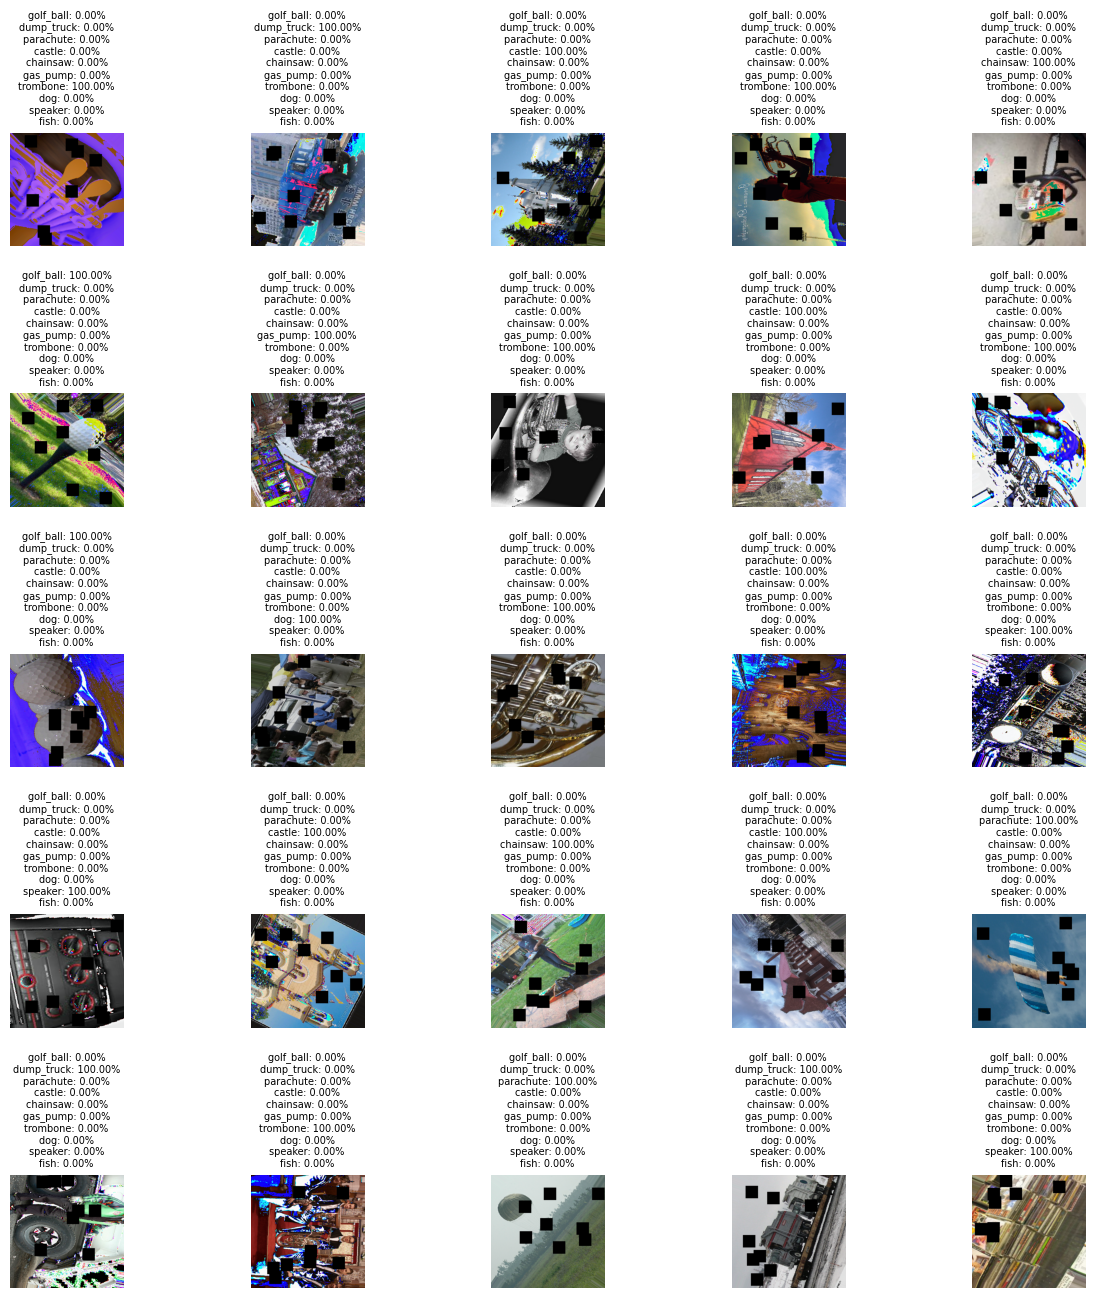

In [ ]:
# @title For Imagenette
# Retrieve the first batch of data from the train dataset
sanity_dataset = read_dataset_imagenette(colab_path_imagenette+'train_shards/', BATCH_SIZE,
                                            augment=True, batch_augment=False, cache=False)

sanity_data = next(iter(sanity_dataset))
images, labels = sanity_data

# Display the first 25 images of the first batch
num_images = 25
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.ravel()

for i in range(num_images):
    img = images[i] * 255
    img = np.squeeze(img.numpy().astype(np.uint8))
    label_tensor = labels[i]

    label_strings = []
    for j, label_prob in enumerate(label_tensor):
        label = [k for k, v in label_map_imagenette.items() if v == j][0]
        percentage = label_prob.numpy() * 100
        label_strings.append(f"{label}: {percentage:.2f}%")

    title = "\n".join(label_strings)
    axes[i].imshow(img)
    axes[i].set_title(title, fontsize=7)
    axes[i].axis('off')

plt.subplots_adjust(hspace=1.3)
plt.show()

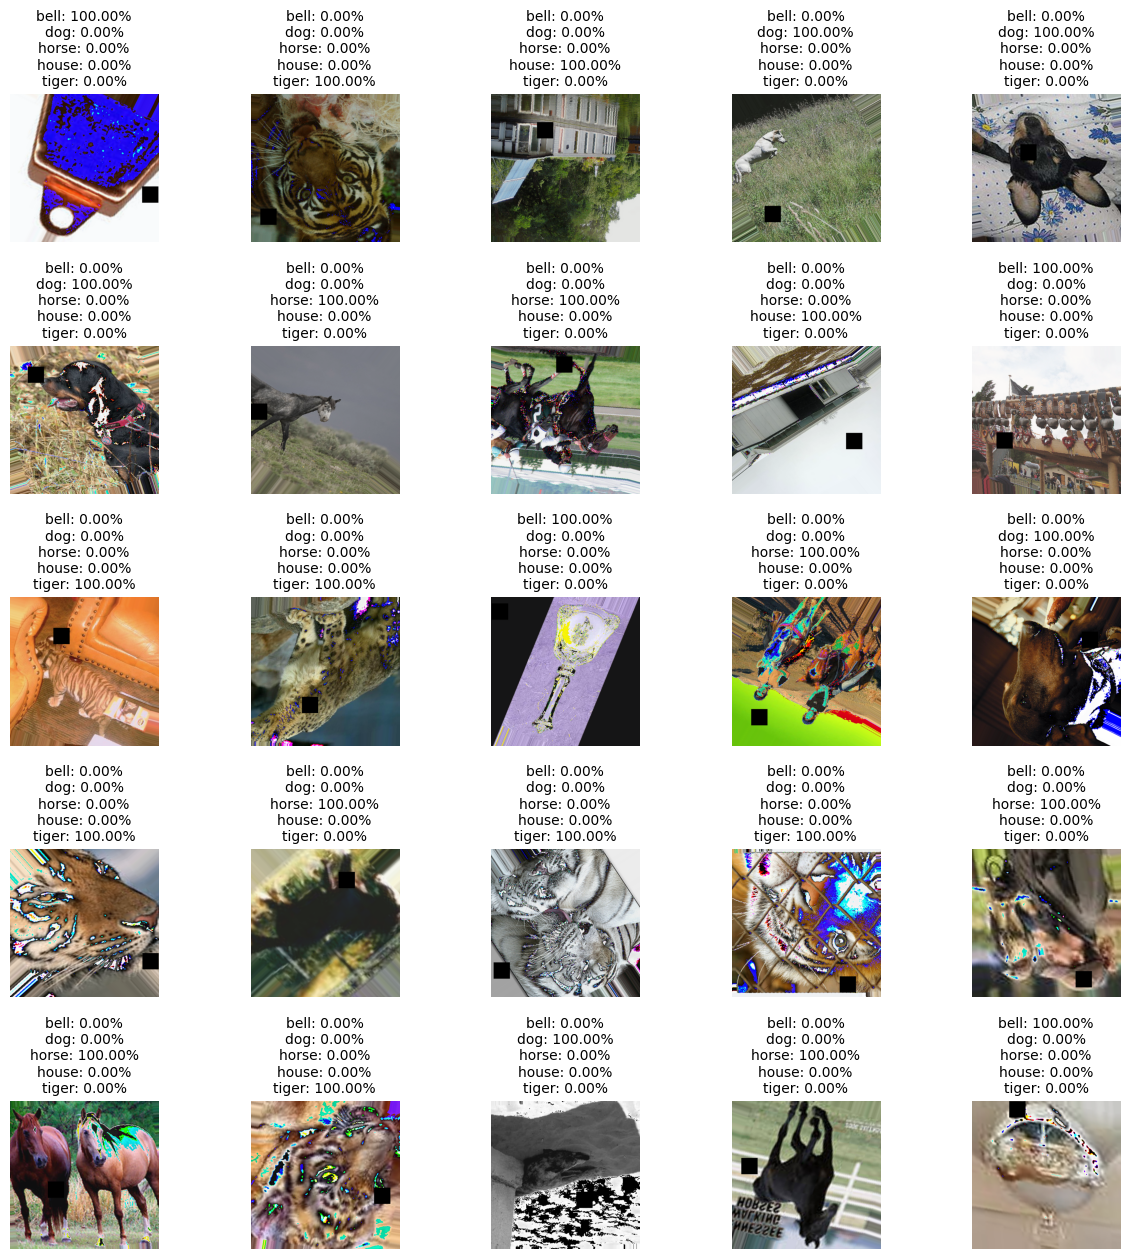

In [ ]:
# @title For class data
# Retrieve the first batch of data from the train dataset
sanity_dataset_ = read_dataset_sharded(colab_path_sharded+'train_shards/', BATCH_SIZE,
                                     augment=True, batch_augment=False, cache=False)

sanity_data = next(iter(sanity_dataset_))
images, labels = sanity_data

# Display the first 25 images of the first batch
num_images = 25
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.ravel()

for i in range(num_images):
    img = images[i] * 255
    img = np.squeeze(img.numpy().astype(np.uint8))
    label_tensor = labels[i]

    label_strings = []
    for j, label_prob in enumerate(label_tensor):
        label = [k for k, v in label_map.items() if v == j][0]
        percentage = label_prob.numpy() * 100
        label_strings.append(f"{label}: {percentage:.2f}%")

    title = "\n".join(label_strings)
    axes[i].imshow(img)
    axes[i].set_title(title, fontsize=10)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.7)
plt.show()

# Models

In [ ]:
# @title Imagenette Model: Adapted from Stage 3 model
from tensorflow.keras.layers import Input,Dense,Conv2D,Add
from tensorflow.keras.layers import SeparableConv2D,ReLU
from tensorflow.keras.layers import BatchNormalization,MaxPool2D
from tensorflow.keras.layers import GlobalAvgPool2D
from tensorflow.keras import Model

# Conv-BatchNorm block
def conv_bn(x, filters, kernel_size, strides=1):
  x = Conv2D(filters=filters,
              kernel_size=kernel_size,
              strides=strides,
              padding='same',
              use_bias=False)(x)
  x = BatchNormalization()(x)
  return x

# DepthwiseSeparableConv-BatchNorm block
def sep_bn(x, filters, kernel_size, strides=1):
    x = SeparableConv2D(filters=filters,
                        kernel_size=kernel_size,
                        strides=strides,
                        padding='same',
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    return x

# First section
def first_section_8(x):
    x = conv_bn(x, filters=32, kernel_size=3, strides=2)
    x = ReLU()(x)
    x = conv_bn(x, filters=64, kernel_size=3, strides=1)
    tensor = ReLU()(x)

    x = sep_bn(tensor, filters=64, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=64, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)

    tensor = conv_bn(tensor, filters=64, kernel_size=1, strides=2)
    x = Add()([tensor,x])

    x = ReLU()(x)
    x = sep_bn(x, filters=128, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=128, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)

    tensor = conv_bn(tensor, filters=128, kernel_size = 1,strides=2)
    x = Add()([tensor,x])

    x = ReLU()(x)
    x = sep_bn(x, filters=512, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=512, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding ='same')(x)

    tensor = conv_bn(tensor, filters=512, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    return x

# Second section
def second_section_8(tensor):
    for _ in range(8):
        x = ReLU()(tensor)
        x = sep_bn(x, filters=512, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters=512, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters=512, kernel_size = 3)
        x = ReLU()(x)
        tensor = Add()([tensor,x])
    return tensor

# Output section
def output_section_8_imagenette(tensor):
    x = ReLU()(tensor)
    x = sep_bn(x, filters=512,  kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=512,  kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding ='same')(x)

    tensor = conv_bn(tensor, filters=512, kernel_size=1, strides =2)
    x = Add()([tensor,x])

    x = sep_bn(x, filters=512,  kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=512,  kernel_size=3)
    x = GlobalAvgPool2D()(x)

    x = Dense(units=10, activation='softmax')(x)

    return x

# Driver code
def Stage5_ImageNette():
    input = Input(shape = (512,512,3))
    x = first_section_8(input)
    x = second_section_8(x)
    output = output_section_8_imagenette(x)

    model = Model(inputs=input, outputs=output)

    optimizer = Adam(learning_rate = 0.0001)

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])

    return model

Stage5_ImageNette().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

# Train

In [ ]:
# @title Model training configs
local_info_path = "/content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/model_files/"

In [ ]:
# @title Model training driver function
def train_model(train_dataset=None, val_dataset=None,
                model_fn=None, model=None, model_name=None,
                epochs=None, prev_count = 0,
                es=False, lr_sched=False):

  with strategy.scope():
    if model is None:
      model = model_fn()
    if model_name is None:
      model_name = model_fn.__name__


  # Callbacks
  early_stop = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.02,
                           verbose=1, patience=5, restore_best_weights=True)

  lr_scheduler = ReduceLROnPlateau(monitor = "val_loss", factor=0.5,
          patience=5, verbose=1)

  log_dir = local_info_path + "logs/" + model_name
  tb = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True,
                            write_images=True, profile_batch = '0,50')

  checkpoint_dir = local_info_path + "checkpoints/" + model_name
  checkpoints = tf.keras.callbacks.ModelCheckpoint(
                        filepath=checkpoint_dir + f"/{model_name}-{prev_count}-{{epoch:02d}}-{{val_loss:.2f}}.h5",
                        monitor='val_loss',
                        verbose=1,
                        save_best_only=True,
                        save_weights_only=False,
                        mode='min',
                        save_freq='epoch')

  callbacks = [tb, checkpoints]
  if es: callbacks.append(early_stop)
  if lr_sched: callbacks.append(lr_scheduler)

  model.fit(train_dataset, epochs=epochs,
            steps_per_epoch = 18000 // BATCH_SIZE,
            validation_data = val_dataset,
            validation_steps = 2250 // BATCH_SIZE,
            callbacks=callbacks)

  return model

### Training Stage 3 model with Imagenette data

In [ ]:
# @title 0-50 epochs
train_dataset = read_dataset_imagenette(colab_path_imagenette+'train_shards/', BATCH_SIZE,
                                     augment=True, batch_augment=False, cache=False)

val_dataset = read_dataset_imagenette(colab_path_imagenette+'val_shards/', BATCH_SIZE,
                                     augment=False, batch_augment=False, cache=False)

imagenette_model= train_model(train_dataset=train_dataset,
                              val_dataset=val_dataset,
                              model_fn=Stage5_ImageNette,
                              model_name="Stage5_ImageNette",
                              epochs=50)

Epoch 1/50
562/562 [==============================] - ETA: 0s - loss: 1.5027 - categorical_accuracy: 0.4928
Epoch 1: val_loss improved from inf to 3.05605, saving model to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/model_files/checkpoints/Stage5_ImageNette/Stage5_ImageNette-0-01-3.06.h5
562/562 [==============================] - 389s 570ms/step - loss: 1.5027 - categorical_accuracy: 0.4928 - val_loss: 3.0561 - val_categorical_accuracy: 0.1571
Epoch 2/50
562/562 [==============================] - ETA: 0s - loss: 1.0582 - categorical_accuracy: 0.6551
Epoch 2: val_loss improved from 3.05605 to 1.40965, saving model to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/model_files/checkpoints/Stage5_ImageNette/Stage5_ImageNette-0-02-1.41.h5
562/562 [==============================] - 319s 568ms/step - loss: 1.0582 - categorical_accuracy: 0.6551 - val_loss: 1.4097 - val_categorical_accuracy: 0.5955
Epoch 3/50
562/562 [

In [ ]:
# @title 33-40 epochs, 0.0003 lr
imagenette_model_path = "/content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/model_files/checkpoints/Stage5_ImageNette/Stage5_ImageNette-0-33-0.65.h5"
imagenette_model = tf.keras.models.load_model(imagenette_model_path)

# Adjust optimzer learning rate to 'magic' adam rate
optimizer = imagenette_model.optimizer
new_learning_rate = 0.0003
optimizer.learning_rate.assign(new_learning_rate)


train_dataset = read_dataset_imagenette(colab_path_imagenette+'train_shards/', BATCH_SIZE,
                                     augment=True, batch_augment=False, cache=False)

val_dataset = read_dataset_imagenette(colab_path_imagenette+'val_shards/', BATCH_SIZE,
                                     augment=False, batch_augment=False, cache=False)

imagenette_model= train_model(train_dataset=train_dataset,
                              val_dataset=val_dataset,
                              model=imagenette_model,
                              model_name="Stage5_ImageNette",
                              epochs=7, prev_count=33,
                              lr_sched=False)

Epoch 1/7
562/562 [==============================] - ETA: 0s - loss: 0.7751 - categorical_accuracy: 0.7623
Epoch 1: val_loss improved from inf to 1.25021, saving model to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/model_files/checkpoints/Stage5_ImageNette/Stage5_ImageNette-33-01-1.25.h5
562/562 [==============================] - 375s 554ms/step - loss: 0.7751 - categorical_accuracy: 0.7623 - val_loss: 1.2502 - val_categorical_accuracy: 0.6612
Epoch 2/7
562/562 [==============================] - ETA: 0s - loss: 0.5709 - categorical_accuracy: 0.8099
Epoch 2: val_loss did not improve from 1.25021
562/562 [==============================] - 311s 554ms/step - loss: 0.5709 - categorical_accuracy: 0.8099 - val_loss: 1.5635 - val_categorical_accuracy: 0.5920
Epoch 3/7
562/562 [==============================] - ETA: 0s - loss: 0.5139 - categorical_accuracy: 0.8307
Epoch 3: val_loss did not improve from 1.25021
562/562 [==============================] - 31

In [ ]:
# @title 40-50 epochs, 0.0003 lr

train_dataset = read_dataset_imagenette(colab_path_imagenette+'train_shards/', BATCH_SIZE,
                                     augment=True, batch_augment=False, cache=False)

val_dataset = read_dataset_imagenette(colab_path_imagenette+'val_shards/', BATCH_SIZE,
                                     augment=False, batch_augment=False, cache=False)

imagenette_model= train_model(train_dataset=train_dataset,
                              val_dataset=val_dataset,
                              model=imagenette_model,
                              model_name="Stage5_ImageNette",
                              epochs=10, prev_count=40,
                              lr_sched=False)

Epoch 1/10
562/562 [==============================] - ETA: 0s - loss: 0.6565 - categorical_accuracy: 0.7810
Epoch 1: val_loss improved from inf to 1.40193, saving model to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/model_files/checkpoints/Stage5_ImageNette/Stage5_ImageNette-40-01-1.40.h5
562/562 [==============================] - 313s 556ms/step - loss: 0.6565 - categorical_accuracy: 0.7810 - val_loss: 1.4019 - val_categorical_accuracy: 0.6058
Epoch 2/10
562/562 [==============================] - ETA: 0s - loss: 0.5247 - categorical_accuracy: 0.8276
Epoch 2: val_loss improved from 1.40193 to 1.19079, saving model to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/model_files/checkpoints/Stage5_ImageNette/Stage5_ImageNette-40-02-1.19.h5
562/562 [==============================] - 313s 556ms/step - loss: 0.5247 - categorical_accuracy: 0.8276 - val_loss: 1.1908 - val_categorical_accuracy: 0.6768
Epoch 3/10
562/562

In [ ]:
# @title 50-60 epochs, 0.0003 lr
train_dataset = read_dataset_imagenette(colab_path_imagenette+'train_shards/', BATCH_SIZE,
                                     augment=True, batch_augment=False, cache=False)

val_dataset = read_dataset_imagenette(colab_path_imagenette+'val_shards/', BATCH_SIZE,
                                     augment=False, batch_augment=False, cache=False)

imagenette_model= train_model(train_dataset=train_dataset,
                              val_dataset=val_dataset,
                              model=imagenette_model,
                              model_name="Stage5_ImageNette",
                              epochs=10, prev_count=50,
                              lr_sched=False)

Epoch 1/10
562/562 [==============================] - ETA: 0s - loss: 0.3391 - categorical_accuracy: 0.8868
Epoch 1: val_loss improved from inf to 0.89380, saving model to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/model_files/checkpoints/Stage5_ImageNette/Stage5_ImageNette-50-01-0.89.h5
562/562 [==============================] - 312s 554ms/step - loss: 0.3391 - categorical_accuracy: 0.8868 - val_loss: 0.8938 - val_categorical_accuracy: 0.7558
Epoch 2/10
562/562 [==============================] - ETA: 0s - loss: 0.2630 - categorical_accuracy: 0.9116
Epoch 2: val_loss improved from 0.89380 to 0.60697, saving model to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/model_files/checkpoints/Stage5_ImageNette/Stage5_ImageNette-50-02-0.61.h5
562/562 [==============================] - 312s 556ms/step - loss: 0.2630 - categorical_accuracy: 0.9116 - val_loss: 0.6070 - val_categorical_accuracy: 0.8353
Epoch 3/10
562/562

In [ ]:
# @title 60-75 epochs, 5e-5 lr

imagenette_model_path = "/content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/model_files/checkpoints/Stage5_ImageNette/Stage5_ImageNette-50-10-0.60.h5"
imagenette_model = tf.keras.models.load_model(imagenette_model_path)

# Adjust optimzer learning rate
optimizer = imagenette_model.optimizer
new_learning_rate = 5e-5
optimizer.learning_rate.assign(new_learning_rate)


train_dataset = read_dataset_imagenette(colab_path_imagenette+'train_shards/', BATCH_SIZE,
                                     augment=True, batch_augment=False, cache=False)

val_dataset = read_dataset_imagenette(colab_path_imagenette+'val_shards/', BATCH_SIZE,
                                     augment=False, batch_augment=False, cache=False)

imagenette_model= train_model(train_dataset=train_dataset,
                              val_dataset=val_dataset,
                              model=imagenette_model,
                              model_name="Stage5_ImageNette",
                              epochs=10, prev_count=60,
                              lr_sched=False)

Epoch 1/10
562/562 [==============================] - ETA: 0s - loss: 0.0812 - categorical_accuracy: 0.9736
Epoch 1: val_loss improved from inf to 0.41114, saving model to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/model_files/checkpoints/Stage5_ImageNette/Stage5_ImageNette-60-01-0.41.h5
562/562 [==============================] - 329s 542ms/step - loss: 0.0812 - categorical_accuracy: 0.9736 - val_loss: 0.4111 - val_categorical_accuracy: 0.8857
Epoch 2/10
562/562 [==============================] - ETA: 0s - loss: 0.0466 - categorical_accuracy: 0.9855
Epoch 2: val_loss improved from 0.41114 to 0.34683, saving model to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/model_files/checkpoints/Stage5_ImageNette/Stage5_ImageNette-60-02-0.35.h5
562/562 [==============================] - 311s 554ms/step - loss: 0.0466 - categorical_accuracy: 0.9855 - val_loss: 0.3468 - val_categorical_accuracy: 0.9112
Epoch 3/10
562/562

## Train final model on class data

In [ ]:
# @title Final Model Architecture: Post Imagenette
imagenette_model_path = "/content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/model_files/checkpoints/Stage5_ImageNette/Stage5_ImageNette-60-03-0.34.h5"
imagenette_model = tf.keras.models.load_model(imagenette_model_path)

new_model = Model(inputs=imagenette_model.inputs, outputs=imagenette_model.layers[-3].output)

x = GlobalAvgPool2D(name='gap_new')(new_model.output)

output = Dense(units=5, activation='softmax')(x)

# Create the final model
final_model = Model(inputs=new_model.inputs, outputs=output)

optimizer = Adam(learning_rate = 5e-5)

final_model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [ ]:
# @title 0-10 epochs, all layers, 5-e5 lr
train_dataset = read_dataset_sharded(colab_path_5_sharded+'train_shards/', BATCH_SIZE,
                                     augment=True, batch_augment=False, cache=False)

val_dataset = read_dataset_sharded(colab_path_5_sharded+'val_shards/', BATCH_SIZE,
                                  augment=False, batch_augment=False, cache=False)

final_model= train_model(train_dataset=train_dataset,
                        val_dataset=val_dataset,
                        model=final_model,
                        model_name="Stage5_Final",
                        epochs=10,
                        lr_sched=False)

Epoch 1/10
562/562 [==============================] - ETA: 0s - loss: 0.7560 - categorical_accuracy: 0.7211
Epoch 1: val_loss improved from inf to 0.56425, saving model to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/model_files/checkpoints/Stage5_Final/Stage5_Final-0-01-0.56.h5
562/562 [==============================] - 396s 588ms/step - loss: 0.7560 - categorical_accuracy: 0.7211 - val_loss: 0.5643 - val_categorical_accuracy: 0.7960
Epoch 2/10
562/562 [==============================] - ETA: 0s - loss: 0.5144 - categorical_accuracy: 0.8136
Epoch 2: val_loss improved from 0.56425 to 0.50362, saving model to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/model_files/checkpoints/Stage5_Final/Stage5_Final-0-02-0.50.h5
562/562 [==============================] - 330s 588ms/step - loss: 0.5144 - categorical_accuracy: 0.8136 - val_loss: 0.5036 - val_categorical_accuracy: 0.8219
Epoch 3/10
562/562 [====================

In [ ]:
# @title 10-50 epochs, all layers, 5-e5 lr
final_model_path = "/content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/model_files/checkpoints/Stage5_Final/Stage5_Final-0-07-0.32.h5"
final_model = tf.keras.models.load_model(final_model_path)

# Adjust optimzer learning rate
optimizer = final_model.optimizer
new_learning_rate = 5e-5
optimizer.learning_rate.assign(new_learning_rate)

train_dataset = read_dataset_sharded(colab_path_5_sharded+'train_shards/', BATCH_SIZE,
                                     augment=True, batch_augment=False, cache=False)

val_dataset = read_dataset_sharded(colab_path_5_sharded+'val_shards/', BATCH_SIZE,
                                  augment=False, batch_augment=False, cache=False)

final_model= train_model(train_dataset=train_dataset,
                        val_dataset=val_dataset,
                        model=final_model,
                        model_name="Stage5_Final",
                        epochs=40, prev_count=10,
                        lr_sched=False)

Epoch 1/40
562/562 [==============================] - ETA: 0s - loss: 0.4131 - categorical_accuracy: 0.8497
Epoch 1: val_loss improved from inf to 0.33206, saving model to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/model_files/checkpoints/Stage5_Final/Stage5_Final-10-01-0.33.h5
562/562 [==============================] - 356s 590ms/step - loss: 0.4131 - categorical_accuracy: 0.8497 - val_loss: 0.3321 - val_categorical_accuracy: 0.8857
Epoch 2/40
562/562 [==============================] - ETA: 0s - loss: 0.3846 - categorical_accuracy: 0.8612
Epoch 2: val_loss did not improve from 0.33206
562/562 [==============================] - 330s 588ms/step - loss: 0.3846 - categorical_accuracy: 0.8612 - val_loss: 0.3497 - val_categorical_accuracy: 0.8790
Epoch 3/40
562/562 [==============================] - ETA: 0s - loss: 0.3657 - categorical_accuracy: 0.8663
Epoch 3: val_loss did not improve from 0.33206
562/562 [==============================] - 330s 588m

In [ ]:
# @title 50-100 epochs, all layers, lr_sched
train_dataset = read_dataset_sharded(colab_path_5_sharded+'train_shards/', BATCH_SIZE,
                                     augment=True, batch_augment=False, cache=False)

val_dataset = read_dataset_sharded(colab_path_5_sharded+'val_shards/', BATCH_SIZE,
                                  augment=False, batch_augment=False, cache=False)

final_model= train_model(train_dataset=train_dataset,
                        val_dataset=val_dataset,
                        model=final_model,
                        model_name="Stage5_Final",
                        epochs=50, prev_count=50,
                        lr_sched=True)

Epoch 1/50
562/562 [==============================] - ETA: 0s - loss: 0.1272 - categorical_accuracy: 0.9541
Epoch 1: val_loss improved from inf to 0.41740, saving model to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/model_files/checkpoints/Stage5_Final/Stage5_Final-50-01-0.42.h5
562/562 [==============================] - 331s 587ms/step - loss: 0.1272 - categorical_accuracy: 0.9541 - val_loss: 0.4174 - val_categorical_accuracy: 0.8799 - lr: 5.0000e-05
Epoch 2/50
562/562 [==============================] - ETA: 0s - loss: 0.1191 - categorical_accuracy: 0.9572
Epoch 2: val_loss improved from 0.41740 to 0.31219, saving model to /content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/model_files/checkpoints/Stage5_Final/Stage5_Final-50-02-0.31.h5
562/562 [==============================] - 330s 587ms/step - loss: 0.1191 - categorical_accuracy: 0.9572 - val_loss: 0.3122 - val_categorical_accuracy: 0.9076 - lr: 5.0000e-05
Epoc

# Evaluate

In [ ]:
# load best val of Stage5_model
model_path = "/content/drive/Othercomputers/MacBook Air 2021/Desktop/Hunter/Deep Learning/Project/model_files/checkpoints/Stage5_Final/Stage5_Final-10-23-0.28.h5"

model = tf.keras.models.load_model(model_path)

In [ ]:
# create the test dataset
test_dataset = read_dataset_sharded(colab_path_5_sharded+'val_shards/', BATCH_SIZE,
                                     augment=False, batch_augment=False, cache=False)

# calculate the number of steps to evaluate
num_steps = 2250 // BATCH_SIZE

# evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset, steps=num_steps)

70/70 [==============================] - 20s 136ms/step - loss: 0.2759 - categorical_accuracy: 0.9071


In [ ]:
%%capture
# predict the labels for the test dataset
y_pred = []
y_true = []
for i, (x, y) in enumerate(test_dataset.take(num_steps)):
    y_pred_batch = model.predict(x)
    y_pred += y_pred_batch.argmax(axis=-1).tolist()
    y_true += y.numpy().argmax(axis=-1).tolist()

In [ ]:
# @title Metrics
# calculate the F1 score
f1 = f1_score(y_true, y_pred, average='macro')

# print the test metrics and F1 score
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)
print('F1 score:', f1)

Test loss: 0.27593034505844116
Test accuracy: 0.9071428775787354
F1 score: 0.9055987823387568


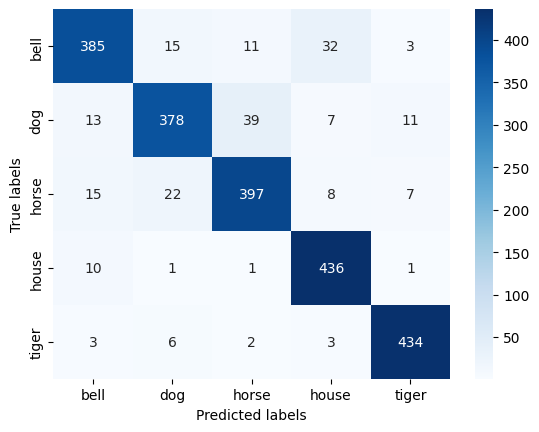

In [ ]:
# @title Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
ticklabels = ["bell", "dog", "horse", "house", "tiger"]
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g', xticklabels=ticklabels, yticklabels=ticklabels)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()